<a href="https://colab.research.google.com/github/TNTTNTTTN/Titanic_Survive_Prediction/blob/main/term_project_code_17011266_%EC%9D%B4%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [835]:
#-*- coding: utf-8 -*-
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

df1 = pd.read_csv("/content/train.csv")
#df2 = pd.read_csv("/content/test.csv")
df1.drop(labels='Survived', axis=1, inplace=True)
df = pd.concat([df1, df2[:]], axis=0)
stscaler = StandardScaler()
mmscaler = MinMaxScaler()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [836]:
def get_title(Name):
  if 'Mrs' in Name or 'Mme' in Name :
    Title='Mrs'
  elif 'Mr' in Name or 'Sir' in Name :
    Title='Mr'
  elif 'Miss' in Name or 'Ms' in Name or 'Mlle' in Name:
    Title='Miss'
  elif 'Master' in Name:
    Title='Master'
  else:
    Title='Else'
  return Title

In [837]:
def classify_age(Age):
  if Age<=10 : tag ="0"
  elif Age <=20 : tag="1"
  elif Age <= 30 : tag="2"
  elif Age <= 40 : tag="3"
  elif Age <= 50 : tag="4"
  elif Age <= 60 : tag ="5"
  else : tag = "6"
  return tag

In [838]:
def classify_fare(Fare):
  if Fare <= 75 : tag="0"
  elif Fare <= 150 : tag=""
  elif Fare <= 225 : tag="2"
  elif Fare <= 300 : tag="3"
  elif Fare <= 375 : tag="4"
  elif Fare <= 450 : tag="5"
  else : tag = "6"
  return tag

In [839]:
df['Title'] = df['Name'].apply(lambda x : get_title(x))
df['Pclass'] = df['Pclass'].astype('string')
title_dic = {0:"Mrs", 1:"Mr", 2:"Miss", 3:"Master", 4:"Else"}
#df['Title'] = df['Title'].map(title_dic).astype(int).fillna(0)

In [840]:
df[df['Title']==3]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [841]:
#df['Sex'] = df['Sex'].map({'male':0, 'female':1}).astype(int)
df.loc[(df['Sex']=='male') & (df['Age'].isnull()) & (df['Title']==title_dic[3]),'Age'] = 10
df.loc[(df['Sex']=='male') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='male']['Age'].mean()
df.loc[(df['Sex']=='female') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='female']['Age'].mean()
#df['Age'] = df['Age'].apply(lambda x : classify_age(x))

In [842]:
df.loc[df['Fare'].isnull(),'Fare'] = df['Fare'].mean()

In [843]:
#df['Ncabin'] = df['Cabin'].str.extract('([A-F])', expand=False)
#df['Ncabin'] = df['Ncabin'].fillna("A")
df.loc[(df['Pclass']=="1") & (df['Fare'] > df[df['Pclass']=='1']['Fare'].median()),'Class'] = 'A'
df.loc[(df['Pclass']=="1") & (df['Fare'] <= df[df['Pclass']=='1']['Fare'].median()),'Class'] = 'B'
df.loc[(df['Pclass']=="2") & (df['Fare'] > df[df['Pclass']=='2']['Fare'].median()),'Class'] = 'C'
df.loc[(df['Pclass']=="2") & (df['Fare'] <= df[df['Pclass']=='2']['Fare'].median()),'Class'] = 'D'
df.loc[(df['Pclass']=="3") & (df['Fare'] > df[df['Pclass']=='3']['Fare'].median()),'Class'] = 'E'
df.loc[(df['Pclass']=="3") & (df['Fare'] <= df[df['Pclass']=='3']['Fare'].median()),'Class'] = 'F'

In [824]:
df[df['Class'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Class


In [464]:
df[(df['Pclass']=='3') & (df['Fare'] > df[df['Pclass']=='3']['Fare'].median())]['Survived'].mean()

KeyError: ignored

In [844]:
df.loc[(df['Pclass']==1) & (df['Cabin'].isnull()),'Cabin'] = 'C'
df.loc[(df['Pclass']==2) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df.loc[(df['Pclass']==3) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
df['Ncabin'] = df['Ncabin'].fillna("N")

In [426]:
def cabin_estimator(i):
    if i<16:
        a = "G"
    elif i<30:
        a = "F"
    elif i<44:
        a = "A"
    elif i<50:
        a = "E"
    elif i<60:
        a = "D"
    elif i<110:
        a = 'C'
    else:
        a = "B"
    return a
df['Cabin'] = df.Fare.apply(lambda x: cabin_estimator(x))

In [845]:
df['Family'] = df['SibSp']+df['Parch']
df.loc[df['Family'] > 3,'Family'] = 4
df['Family'] = df['Family'].astype('string')

In [846]:
embark_dic = {0:"C", 1:"S", 2:"Q"}
df['Embarked'].fillna(df['Embarked'].dropna().mode()[0], inplace=True)
for i in range(3):
  df.loc[(df['Pclass']==i+1) & (df['Fare'].isnull()),'Fare'] = df[df['Pclass']==i+1]['Fare'].dropna().median()
#df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
#df['Fare'] = df['Fare'].apply(lambda x : classify_fare(x))

In [800]:
df[df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Class,Ncabin,Family


In [801]:
df['Sex'].value_counts()

male      266
female    152
Name: Sex, dtype: int64

In [847]:
stscaler.fit(df[['Age','Fare']])
scaled = stscaler.transform(df[['Age','Fare']])
mmscaler.fit(scaled)
output = mmscaler.transform(scaled)
output = pd.DataFrame(output, columns=['Age','Fare'])
df['Age'] = output['Age']
df['Fare'] = output['Fare']
#df['Ncabin'] = df['Ncabin'].astype(int)

<Axes: xlabel='Age', ylabel='Fare'>

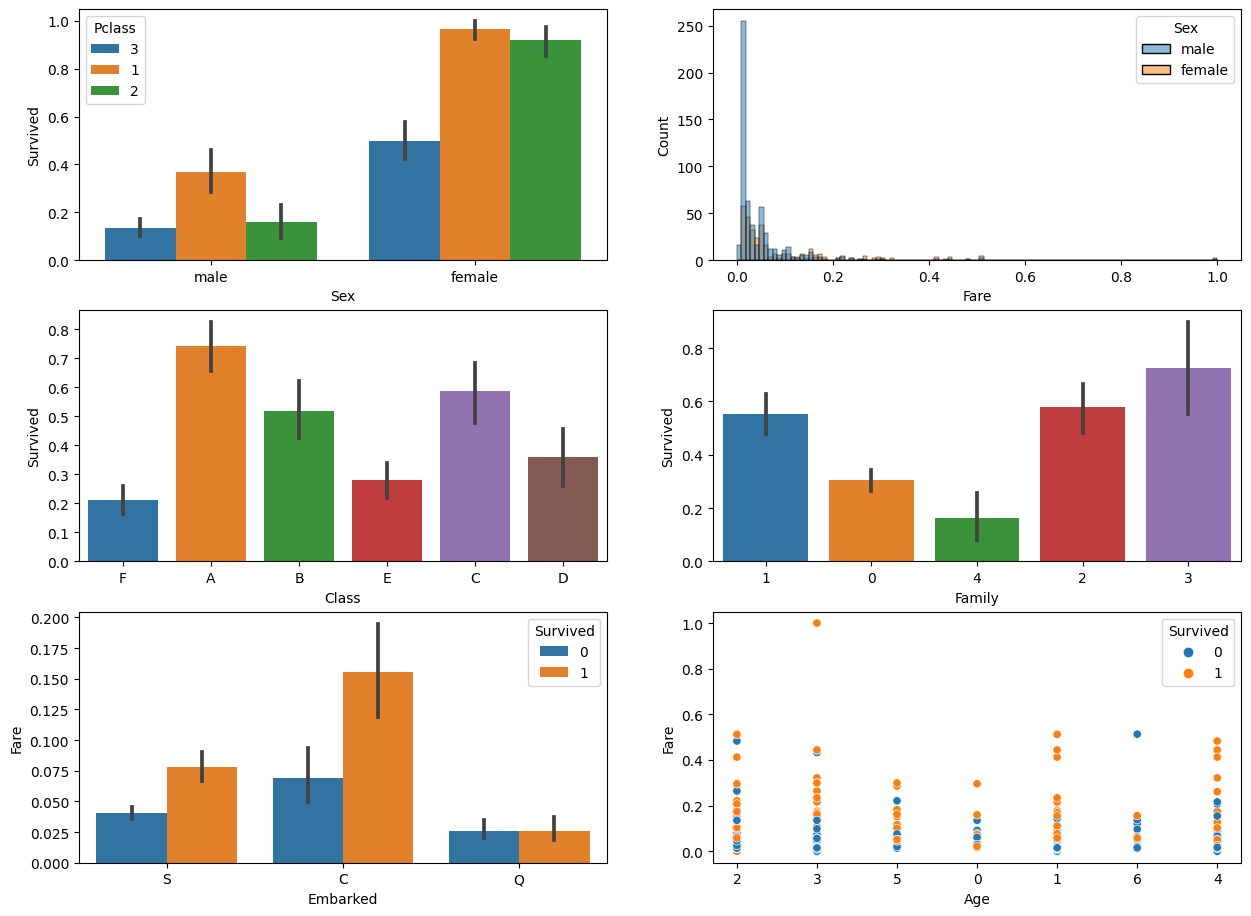

In [243]:
plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=df)
plt.subplot(4,2,2)
sns.histplot(x='Fare', hue='Sex', data=df)
plt.subplot(4,2,3)
sns.barplot(x='Class', y='Survived', data=df)
plt.subplot(4,2,4)
sns.barplot(x='Family', y='Survived', data=df)
plt.subplot(4,2,5)
sns.barplot(x='Embarked', y='Fare',hue='Survived', data=df)
plt.subplot(4,2,6)
sns.scatterplot(x='Age', y='Fare',hue='Survived', data=df)

In [848]:
df.drop(['PassengerId','Name', 'Ticket', 'SibSp','Parch'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   string 
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   float64
 3   Fare      1309 non-null   float64
 4   Cabin     295 non-null    object 
 5   Embarked  1309 non-null   object 
 6   Title     1309 non-null   object 
 7   Class     1309 non-null   object 
 8   Ncabin    1309 non-null   object 
 9   Family    1309 non-null   string 
dtypes: float64(2), object(6), string(2)
memory usage: 112.5+ KB


In [849]:
df.drop(['Sex','Cabin','Embarked'],axis=1,inplace=True)

In [578]:
data = ['Pclass','Sex','Embarked','Title','Ncabin','Family']
#data= ['Age','Title','Class','Family']
for column in data:
  le = LabelEncoder()
  le = le.fit(df[column])
  df[column] = le.transform(df[column])
me = MinMaxScaler()
me = me.fit(df[data])
df[data] = me.transform(df[data])

In [673]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    string 
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   Fare      418 non-null    float64
 4   Embarked  418 non-null    object 
 5   Title     418 non-null    object 
 6   Ncabin    418 non-null    object 
 7   Family    418 non-null    string 
dtypes: float64(2), object(4), string(2)
memory usage: 26.2+ KB


In [850]:
#Survive = df.iloc[:,0]
#df = pd.get_dummies(df.iloc[:,1:])
df = pd.get_dummies(df,drop_first=True)
#df = pd.concat([Survive, df],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           1309 non-null   float64
 1   Fare          1309 non-null   float64
 2   Pclass_2      1309 non-null   uint8  
 3   Pclass_3      1309 non-null   uint8  
 4   Title_Master  1309 non-null   uint8  
 5   Title_Miss    1309 non-null   uint8  
 6   Title_Mr      1309 non-null   uint8  
 7   Title_Mrs     1309 non-null   uint8  
 8   Class_B       1309 non-null   uint8  
 9   Class_C       1309 non-null   uint8  
 10  Class_D       1309 non-null   uint8  
 11  Class_E       1309 non-null   uint8  
 12  Class_F       1309 non-null   uint8  
 13  Ncabin_B      1309 non-null   uint8  
 14  Ncabin_C      1309 non-null   uint8  
 15  Ncabin_D      1309 non-null   uint8  
 16  Ncabin_E      1309 non-null   uint8  
 17  Ncabin_F      1309 non-null   uint8  
 18  Ncabin_G      1309 non-null  

In [851]:
df.head()

,Age,Fare,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Class_B,Class_C,...,Ncabin_C,Ncabin_D,Ncabin_E,Ncabin_F,Ncabin_G,Ncabin_N,Family_1,Family_2,Family_3,Family_4
0,0.273456,0.014151,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0.473882,0.139136,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0.323563,0.015469,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.436302,0.103644,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,0,0
4,0.436302,0.015713,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [852]:
dataset = df.values
X = dataset[:,1:]
Y = dataset[:,0]
n_fold = 10
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
accuracy =[]

In [833]:
from keras import regularizers

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)
#history = model.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#          callbacks=[early_stopping_callback])
#model.fit(X, Y, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#         callbacks=[early_stopping_callback])
for train, test in skf.split(X, Y):
    model = Sequential()
    model.add(Dense(16, input_dim=24, activation='sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
    model.fit(X[train], Y[train], validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping_callback])
    k_accuracy = "%.4f" % (model.evaluate(X[test], Y[test])[1])
    accuracy.append(float(k_accuracy))
print("\n %.f fold mean accuracy:" % n_fold, sum(accuracy)/n_fold)

ValueError: ignored

In [783]:
accuracy

[0.8222, 0.809, 0.8652, 0.8764, 0.8539, 0.8202, 0.7978, 0.8202, 0.7865, 0.809]

In [784]:
from keras import regularizers
model = Sequential()
model.add(Dense(16, input_dim=24, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
#model.add(Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X, Y, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
56/56 [==============================] - 1s 2ms/step - loss: 0.6751 - accuracy: 0.5926
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6609 - accuracy: 0.6128
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.6016
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6483 - accuracy: 0.6218
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6239 - accuracy: 0.6263
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 0.6272 - accuracy: 0.6543
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.6835
Epoch 8/100
56/56 [==============================] - 0s 2ms/step - loss: 0.5911 - accuracy: 0.7048
Epoch 9/100
56/56 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.6880
Epoch 10/100
56/56 [==============================] - 0s 2ms/step - loss: 0.5690 - accuracy: 0.7082
Epoch 11/

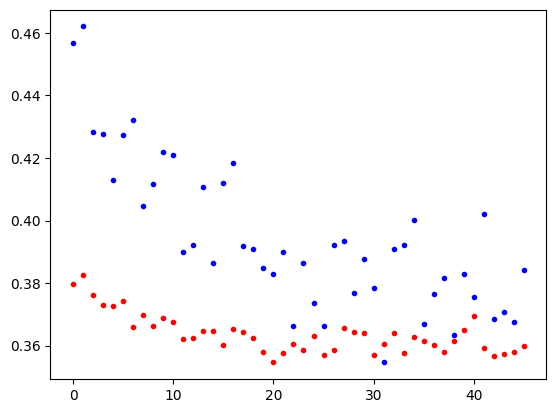

9/9 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7873

 Accurarcy: 0.7873


In [ ]:
model_vloss = history.history['val_loss'][10:]
model_loss = history.history['loss'][10:]
x_len = np.arange(len(model_loss))

plt.plot(x_len, model_vloss, "o", c="red", markersize=3)
plt.plot(x_len, model_loss, "o", c="blue", markersize=3)
plt.show()

print("\n Accurarcy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

In [785]:
model.save('please.h5')

In [853]:
model = load_model('please.h5')
Y_prediction = model.predict(dataset).flatten()




41/41 [==============================] - 0s 1ms/step


In [ ]:
len(Y_prediction[891:])

418

In [855]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = Y_prediction[891:]
submission.loc[submission['Survived'] < 0.5 ,'Survived'] = 0
submission.loc[submission['Survived'] >= 0.5 ,'Survived'] = 1
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('sub.csv',index=False)

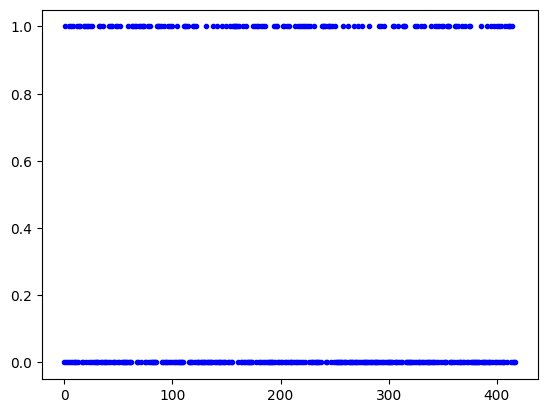

In [861]:
#Y_prediction = model.predict(X_test).flatten()
osub = pd.read_csv("sub.csv")

#Y_pred_old = osub['Survived']

#plt.plot(range(len(Y_test)), Y_test, "o", c="red", markersize=3)
plt.plot(range(len(osub)), osub['Survived'], "o", c="blue", markersize=3)
#plt.plot(range(len(Y_prediction)), Y_pred_old, "o", c='red', markersize=3)
plt.show()

In [ ]:
t = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.DataFrame(t).value_counts()

KeyError: ignored

In [ ]:
df['FBand'] = pd.cut(df['Fare'], 7)
df[['FBand','Survived']].groupby(['FBand'], as_index=False).mean()

In [ ]:
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
pd.crosstab(df['Ncabin'],df['Survived'])

In [ ]:
df[['Embarked','Fare']].groupby(['Embarked'], as_index=False).mean()
df[['Pclass','Fare']].groupby(['Pclass'], as_index=False).mean()

In [ ]:
df.info()
df[df['Embarked'].isnull()]

In [ ]:
df[['Ncabin','Survived']].groupby('Ncabin').mean()

In [858]:
submit1 = pd.read_csv('sub.csv')
submit2 = pd.read_csv('sub1.csv')

In [859]:
submit1[submit1['Survived'] == submit2['Survived']]

,PassengerId,Survived
0,892,0
2,894,0
3,895,0
4,896,1
5,897,0
...,...,...
411,1303,1
413,1305,0
414,1306,1
415,1307,0
